# **Pyspark**

In [ ]:
!pip install pyspark findspark

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession
import findspark
import time
import re

In [ ]:
!wget -O "dataset.zip" "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/29hdbdzx2r-1.zip"

--2024-10-18 11:30:29--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/29hdbdzx2r-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.68.93, 52.218.118.82, 52.92.18.82, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.68.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 739335216 (705M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 705.08M  30.6MB/s    in 24s     

2024-10-18 11:30:54 (29.4 MB/s) - ‘dataset.zip’ saved [739335216/739335216]



In [ ]:
!unzip -x dataset.zip

Archive:  dataset.zip
  inflating: CSE-CIC-IDS2018/Brute Force -XSS.csv  
  inflating: CSE-CIC-IDS2018/Brute Force -Web.csv  
  inflating: CSE-CIC-IDS2018/DDOS attack-LOIC-UDP.csv  
  inflating: CSE-CIC-IDS2018/SQL Injection.csv  
  inflating: CSE-CIC-IDS2018/DoS attacks-Slowloris.csv  
  inflating: CSE-CIC-IDS2018/DoS attacks-GoldenEye.csv  
  inflating: CSE-CIC-IDS2018/DoS attacks-SlowHTTPTest.csv  
  inflating: CSE-CIC-IDS2018/Bot.csv  
  inflating: CSE-CIC-IDS2018/DDOS attack-HOIC.csv  
  inflating: CSE-CIC-IDS2018/Infilteration.csv  
  inflating: CSE-CIC-IDS2018/FTP-BruteForce.csv  
  inflating: CSE-CIC-IDS2018/DoS attacks-Hulk.csv  
  inflating: CSE-CIC-IDS2018/DDoS attacks-LOIC-HTTP.csv  
  inflating: CSE-CIC-IDS2018/SSH-Bruteforce.csv  


In [ ]:
findspark.init()

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("ReadMultipleCSV").getOrCreate()

In [ ]:
file_path = '/content/CSE-CIC-IDS2018/*.csv'

# Read multiple CSV files using a wildcard
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+-----------+-----------+-------------+-----------------+------------+------------+-----------+------------+-----------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------------+------------------+-----------+-----------+------------------+-----------+-----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+---

In [ ]:
# Assume df is your DataFrame and the label column is 'label'

# First, let's calculate the number of instances for each label
label_distribution = df.groupBy('Label').count()

# Define the train-test split ratio
train_ratio = 0.8

# Initialize empty DataFrames for train and test sets
train_df = None
test_df = None

# Stratify the sampling for each label
for row in label_distribution.collect():
    label_value = row['Label']

    # Filter the DataFrame for the current label
    df_label = df.filter(F.col('Label') == label_value)

    # Add a random number column specifically for the current label subset
    df_label = df_label.withColumn('rand', F.rand())

    # Split the current label's rows into train and test sets based on random value
    train_df_label = df_label.where(F.col('rand') < train_ratio)
    test_df_label = df_label.where(F.col('rand') >= train_ratio)

    # Combine with the overall train and test DataFrames
    if train_df is None:
        train_df = train_df_label
        test_df = test_df_label
    else:
        train_df = train_df.union(train_df_label)
        test_df = test_df.union(test_df_label)

# Drop the 'rand' column after splitting
train_df = train_df.drop('rand')
test_df = test_df.drop('rand')

# Now you have stratified train and test sets

In [ ]:
train_df.groupBy("Label").count().show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|              Benign|5501091|
|                 Bot| 229067|
|    DDOS attack-HOIC| 548207|
|DDoS attacks-LOIC...| 461004|
|    DoS attacks-Hulk| 369964|
|DoS attacks-SlowH...| 111735|
|      FTP-BruteForce| 154674|
|       Infilteration| 129723|
|      SSH-Bruteforce| 150123|
|DoS attacks-Golde...|  33103|
|       SQL Injection|     76|
|DoS attacks-Slowl...|   8775|
|    Brute Force -XSS|    160|
|DDOS attack-LOIC-UDP|   1383|
|    Brute Force -Web|    477|
+--------------------+-------+



In [ ]:
test_df.groupBy("Label").count().show()

+--------------------+-------+
|               Label|  count|
+--------------------+-------+
|              Benign|1375822|
|                 Bot|  57124|
|    DDOS attack-HOIC| 137805|
|DDoS attacks-LOIC...| 115187|
|    DoS attacks-Hulk|  91948|
|DoS attacks-SlowH...|  28155|
|      FTP-BruteForce|  38686|
|       Infilteration|  32211|
|      SSH-Bruteforce|  37466|
|DoS attacks-Golde...|   8405|
|       SQL Injection|     11|
|DoS attacks-Slowl...|   2215|
|    Brute Force -XSS|     70|
|DDOS attack-LOIC-UDP|    347|
|    Brute Force -Web|    134|
+--------------------+-------+



In [ ]:
# Save the training DataFrame
train_df.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/cic_cse_2018/train_df.parquet")

In [ ]:
# Save the testing DataFrame
test_df.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/cic_cse_2018/test_df.parquet")

# **Reading pyspark df**

In [ ]:
findspark.init()

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder.appName("ReadMultipleCSV").getOrCreate()

In [ ]:
# Load the training DataFrame
train_df = spark.read.parquet("/content/drive/MyDrive/samira/cic_cse_2018/train_df.parquet")
# Load the testing DataFrame
test_df = spark.read.parquet("/content/drive/MyDrive/samira/cic_cse_2018/test_df.parquet")

In [ ]:
len(train_df.columns)-1

78

In [ ]:
train_df.show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+----------------+---------------+-----------+-----------+----------------+------------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+-----------------+-----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+--------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------

In [ ]:
test_df.show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+----------------+---------------+-----------+-----------+------------------+------------------+------------+------------+-----------+------------------+------------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+----

# **Label encoder**

In [ ]:
from pyspark.ml.feature import StringIndexer


In [ ]:
# Create the StringIndexer for the 'Label' column
indexer = StringIndexer(inputCol="Label", outputCol="Label_indexed", handleInvalid="error")

In [ ]:
# Fit the indexer to the training data
indexer_model = indexer.fit(train_df)

In [ ]:
# Transform the train_df and test_df
train_df = indexer_model.transform(train_df)


In [ ]:
test_df = indexer_model.transform(test_df)

In [ ]:
# Show the mapping between categories and indices
labels = indexer_model.labels
label_to_index = {label: index for index, label in enumerate(labels)}

print("Category to Index Mapping:")
print(label_to_index)

index_to_label = {v:k for k, v in label_to_index.items()}

Category to Index Mapping:
{'Benign': 0, 'DDOS attack-HOIC': 1, 'DDoS attacks-LOIC-HTTP': 2, 'DoS attacks-Hulk': 3, 'Bot': 4, 'FTP-BruteForce': 5, 'SSH-Bruteforce': 6, 'Infilteration': 7, 'DoS attacks-SlowHTTPTest': 8, 'DoS attacks-GoldenEye': 9, 'DoS attacks-Slowloris': 10, 'DDOS attack-LOIC-UDP': 11, 'Brute Force -Web': 12, 'Brute Force -XSS': 13, 'SQL Injection': 14}


In [ ]:
# Show the encoded DataFrame
test_df.select("Label", "Label_indexed").show()

+------+-------------+
| Label|Label_indexed|
+------+-------------+
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
|Benign|          0.0|
+------+-------------+
only showing top 20 rows



In [ ]:
train_df = train_df.drop("Label")
test_df = test_df.drop("Label")

# **Feature scaling**

In [ ]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

In [ ]:
# Step 1: List of columns to scale, excluding 'Label_indexed'
columns_to_scale = [col for col in train_df.columns if col != "Label_indexed"]

# Step 2: Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")

# Step 3: Apply StandardScaler to the assembled vector
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Step 4: Create a pipeline with assembler and scaler
pipeline = Pipeline(stages=[assembler, scaler])

# Step 5: Fit the pipeline to the train_df
pipeline_model = pipeline.fit(train_df)

# Step 6: Transform both train_df and test_df
train_df = pipeline_model.transform(train_df)
test_df = pipeline_model.transform(test_df)


# **Dimensionality reduction (PCA)**

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCAModel


In [ ]:
train_df = train_df.drop('pca_features')
test_df = test_df.drop('pca_features')

In [ ]:
# Step 7: Define the number of principal components
num_components = 14  # Change this to the number of components you want
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")

# Step 8: Fit the PCA model to the training data
pca_model = pca.fit(train_df)

In [ ]:
pca_model.save("/content/drive/MyDrive/samira/pca_model/pca_model")

In [ ]:
pca_model = PCAModel.load("/content/drive/MyDrive/samira/pca_model/pca_model")


In [ ]:
# Step 9: Transform the train_df with PCA
train_df = pca_model.transform(train_df)
explained_variance = pca_model.explainedVariance.toArray()
print("Explained Variance by each Principal Component:")
print(explained_variance)
print(sum(explained_variance))




Explained Variance by each Principal Component:
[0.16505728 0.1325433  0.08444081 0.07450816 0.06757306 0.05377497
 0.05111668 0.0426197  0.03931039 0.0349954  0.02949279 0.02801139
 0.02534582 0.0167648 ]
0.8455545544071812


In [ ]:
# Optional: Transform the test_df as well if needed
test_df = pca_model.transform(test_df)

# **Imports and avaluation functions**

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

In [ ]:
def classification_report(df: DataFrame, label_col: str, prediction_col: str, probability_col: str):
    # Get unique classes
    labels = df.select(label_col).distinct().rdd.flatMap(lambda x: x).collect()

    print(f"\nOverall Metrics:")

    # Overall metrics
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedRecall")

    # Print overall metrics
    print(f"Accuracy  = {evaluator_accuracy.evaluate(df):.4f}")
    print(f"F1 Score  = {evaluator_f1.evaluate(df):.4f}")
    print(f"Precision = {evaluator_precision.evaluate(df):.4f}")
    print(f"Recall    = {evaluator_recall.evaluate(df):.4f}")

    print(f"\nPer-Class Metrics:")

    # Loop over each class and calculate precision, recall, F1 score for each class
    for label in sorted(labels):
        print(f"\nMetrics for class {label} {index_to_label[label]}:")

        label_str = str(label).replace(".", "_")

        # Create a new column for binary class classification (1.0 for current class, 0.0 for others)
        df_binary = df.withColumn(f"is_class_{label_str}", when(col(label_col) == label, 1.0).otherwise(0.0).cast(DoubleType()))

        # Adjust the prediction column for binary classification
        df_binary = df_binary.withColumn(f"pred_class_{label_str}", when(col(prediction_col) == label, 1.0).otherwise(0.0).cast(DoubleType()))

        # Precision, recall, F1 score for each class
        evaluator_precision_class = MulticlassClassificationEvaluator(labelCol=f"is_class_{label_str}", predictionCol=f"pred_class_{label_str}", metricName="precisionByLabel")
        evaluator_recall_class = MulticlassClassificationEvaluator(labelCol=f"is_class_{label_str}", predictionCol=f"pred_class_{label_str}", metricName="recallByLabel")
        evaluator_f1_class = MulticlassClassificationEvaluator(labelCol=f"is_class_{label_str}", predictionCol=f"pred_class_{label_str}", metricName="fMeasureByLabel")

        # Compute per-class precision, recall, F1
        precision_class = evaluator_precision_class.evaluate(df_binary)
        recall_class = evaluator_recall_class.evaluate(df_binary)
        f1_class = evaluator_f1_class.evaluate(df_binary)

        print(f"Precision = {precision_class:.4f}")
        print(f"Recall    = {recall_class:.4f}")
        print(f"F1 Score  = {f1_class:.4f}")




# **XGBoost**

In [ ]:
!pip install dask[complete] dask-ml
!pip install dask[parquet] fastparquet
!pip install dask[complete] xgboost dask-xgboost dask-ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [ ]:
import dask.dataframe as dd
import pandas as pd
import dask_xgboost
from dask.distributed import Client
from sklearn.metrics import classification_report
import dask.dataframe as dd
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(


In [ ]:
#train_df.select("Label_indexed", "pca_features").write.mode("overwrite").parquet("/content/drive/MyDrive/samira/train_df_cleaned.parquet")
#test_df.select("Label_indexed", "pca_features").write.mode("overwrite").parquet("/content/drive/MyDrive/samira/test_df_cleaned.parquet")

In [ ]:
train_df = dd.read_parquet("/content/drive/MyDrive/samira/train_df_cleaned.parquet")
test_df = dd.read_parquet("/content/drive/MyDrive/samira/test_df_cleaned.parquet")

In [ ]:
def extract_pca_features(row):
    # Assuming pca_features is a list or dictionary with 14 values
    # Extract the features as a list (if it's a dictionary, you can convert to list)
    print(row)
    pca_values = row['values']  # You might need to adjust depending on the exact format
    return pd.Series(pca_values)  # Convert the list to a pandas Series

In [ ]:
pca_features = train_df['pca_features'].apply(extract_pca_features, meta=(None, 'object'))
# Now, add these features to the Dask DataFrame
for i in range(14):
    train_df[f'pca_feature_{i+1}'] = pca_features[i]

# Drop the original 'pca_features' column as it's no longer needed
train_df = train_df.drop(columns=['pca_features'])

# The target is in 'Label_indexed'
X_train = train_df[[f'pca_feature_{i+1}' for i in range(14)]]  # The features
y_train = train_df['Label_indexed']  # The target (labels)


In [ ]:
pca_features_test = test_df['pca_features'].apply(extract_pca_features, meta=(None, 'object'))
# Now, add these features to the Dask DataFrame
for i in range(14):
    test_df[f'pca_feature_{i+1}'] = pca_features_test[i]

# Drop the original 'pca_features' column as it's no longer needed
test_df = test_df.drop(columns=['pca_features'])

# The target is in 'Label_indexed'
X_test = test_df[[f'pca_feature_{i+1}' for i in range(14)]]  # The features
y_test = test_df['Label_indexed']  # The target (labels)

In [ ]:
# Start a Dask client for parallel computation
client = Client()



/usr/local/lib/python3.10/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45021 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33873
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:45021/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37137'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45157'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43157', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43157
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52368
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33267', name: 0, status: init, memory:

In [ ]:
# Convert Dask DataFrame to Dask arrays (this is required by dask-xgboost)
X_train_dask = X_train.to_dask_array(lengths=True)
y_train_dask = y_train.to_dask_array(lengths=True)

X_test_dask = X_test.to_dask_array(lengths=True)
y_test_dask = y_test.to_dask_array(lengths=True)





ValueError: Cannot set a DataFrame with multiple columns to the single column pca_feature_1

In [ ]:
# Set up XGBoost parameters for multiclass classification
params = {
    'objective': 'multi:softmax',  # Use 'multi:softmax' for multiclass classification
    'num_class': len(y_train.unique()),  # Number of classes in your target variable
    'eval_metric': 'mlogloss',  # Multiclass logarithmic loss
  #  'max_depth': 6,
  #  'learning_rate': 0.1,
  #  'n_estimators': 100
}

# Train the model using Dask-XGBoost
dask_model = dask_xgboost.train(client, params, X_train_dask, y_train_dask, num_boost_round=100)



# **Decesion tree**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel


In [ ]:
# Step 1: Define the Decision Tree model
# Train the model on train_df_scaled
dt = DecisionTreeClassifier(labelCol="Label_indexed", featuresCol="pca_features")
# Step 2: Train the model on the training data
start_train_time = time.time()
dt_model = dt.fit(train_df)
training_time = time.time() - start_train_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 414.74 seconds


In [ ]:
dt_model.save("/content/drive/MyDrive/samira/dt_model/dt_model")

In [ ]:
# Step 3: Transform on train_df and test_df
train_predictions = dt_model.transform(train_df)
test_predictions = dt_model.transform(test_df)

In [ ]:
# Save train predictions
train_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/dt_model/train_predictions.parquet")
# Save test predictions
test_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/dt_model/test_predictions.parquet")

In [ ]:
print("Training Data Classification Report:")
classification_report(train_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.9420
F1 Score  = 0.9288
Precision = 0.9256
Recall    = 0.9420

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9796
Recall    = 0.8469
F1 Score  = 0.9084

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9997
Recall    = 0.9993
F1 Score  = 0.9995

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9998
F1 Score  = 0.9985

Metrics for class 4.0 Bot:
Precision = 0.9832
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9969
Recall    = 0.9926
F1 Score  = 0.9948

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9995
Recall    = 0.9988
F1 Score  = 0.9991

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9916
Recall    = 0.9953
F1

In [ ]:
print("Test Data Classification Report:")
classification_report(test_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.9422
F1 Score  = 0.9291
Precision = 0.9259
Recall    = 0.9422

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9794
Recall    = 0.8476
F1 Score  = 0.9088

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9997
Recall    = 0.9992
F1 Score  = 0.9995

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9998
F1 Score  = 0.9985

Metrics for class 4.0 Bot:
Precision = 0.9833
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9969
Recall    = 0.9926
F1 Score  = 0.9948

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9995
Recall    = 0.9988
F1 Score  = 0.9991

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9917
Recall    = 0.9952
F1 Sco

In [ ]:
dt_model = DecisionTreeClassificationModel.load("/content/drive/MyDrive/samira/dt_model/dt_model")


In [ ]:
n=1000000
start_train_time = time.time()
test_predictions_sample = dt_model.transform(test_df.limit(n))
training_time = (time.time() - start_train_time)/n
print(f"Inference Time: {training_time*1000} msec")

Inference Time: 0.00025729775428771977 msec


# **Random forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel


In [ ]:
# Step 1: Define the Decision Tree model
rf = RandomForestClassifier(labelCol="Label_indexed", featuresCol="pca_features")

# Step 2: Train the model on the training data
# Step 2: Train the model on the training data
start_train_time = time.time()
rf_model = rf.fit(train_df)
training_time = time.time() - start_train_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 554.05 seconds


In [ ]:
rf_model.save("/content/drive/MyDrive/samira/rf_model/rf_model")

In [ ]:
# Step 3: Transform on train_df and test_df
train_predictions = rf_model.transform(train_df)
test_predictions = rf_model.transform(test_df)

In [ ]:
# Save train predictions
train_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/rf_model/train_predictions.parquet")
# Save test predictions
test_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/rf_model/test_predictions.parquet")

In [ ]:
print("Training Data Classification Report:")
classification_report(train_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.9235
F1 Score  = 0.9013
Precision = 0.8980
Recall    = 0.9235

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9900
Recall    = 0.7944
F1 Score  = 0.8815

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9960
Recall    = 1.0000
F1 Score  = 0.9980

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9987
F1 Score  = 0.9980

Metrics for class 4.0 Bot:
Precision = 0.9843
Recall    = 1.0000
F1 Score  = 0.9921

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9995
Recall    = 0.9832
F1 Score  = 0.9913

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9853
Recall    = 1.0000
F1 Score  = 0.9926

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9854
Recall    = 1.0000
F1

In [ ]:
print("Test Data Classification Report:")
classification_report(test_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.9239
F1 Score  = 0.9018
Precision = 0.8985
Recall    = 0.9239

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9896
Recall    = 0.7954
F1 Score  = 0.8819

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9961
Recall    = 1.0000
F1 Score  = 0.9981

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9987
F1 Score  = 0.9979

Metrics for class 4.0 Bot:
Precision = 0.9844
Recall    = 1.0000
F1 Score  = 0.9921

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9995
Recall    = 0.9832
F1 Score  = 0.9913

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9853
Recall    = 1.0000
F1 Score  = 0.9926

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9856
Recall    = 1.0000
F1 Sco

In [ ]:
rf_model = RandomForestClassificationModel.load("/content/drive/MyDrive/samira/rf_model/rf_model")


In [ ]:
n=1000000
start_train_time = time.time()
test_predictions_sample = rf_model.transform(test_df.limit(n))
training_time = (time.time() - start_train_time)/n
print(f"Inference Time: {training_time*1000} msec")

Inference Time: 0.00012462615966796873 msec


# **logistic regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel


In [ ]:
# Step 1: Train the logistic regression model on train_df_scaled

# Create a Logistic Regression model for multiclass classification
lr = LogisticRegression(featuresCol="pca_features", labelCol="Label_indexed")



In [ ]:
# Train the model on train_df_scaled
start_train_time = time.time()
lr_model = lr.fit(train_df)
training_time = time.time() - start_train_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 800.82 seconds


In [ ]:

# Step 2: Make predictions on both train and test datasets
train_predictions = lr_model.transform(train_df)

In [ ]:
test_predictions = lr_model.transform(test_df)



In [ ]:
lr_model.save("/content/drive/MyDrive/samira/lr_model/lr_model")
# Save train predictions
train_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/lr_model/train_predictions.parquet")
# Save test predictions
test_predictions.write.mode("overwrite").parquet("/content/drive/MyDrive/samira/lr_model/test_predictions.parquet")

**Load LR model and it predictions**

In [ ]:

# Load the model
lr_model = LogisticRegressionModel.load("/content/drive/MyDrive/samira/lr_model/lr_model")

# Load the predictions
train_predictions = spark.read.parquet("/content/drive/MyDrive/samira/lr_model/train_predictions.parquet")
test_predictions = spark.read.parquet("/content/drive/MyDrive/samira/lr_model/test_predictions.parquet")


In [ ]:
# Step 4: Print the classification report for train data
print("Training Data Classification Report:")
classification_report(train_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.7924
F1 Score  = 0.7260
Precision = 0.7079
Recall    = 0.7924

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.8765
Recall    = 0.3853
F1 Score  = 0.5353

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 0.9281
Recall    = 0.9906
F1 Score  = 0.9584

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9692
Recall    = 0.9965
F1 Score  = 0.9826

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9972
F1 Score  = 0.9972

Metrics for class 4.0 Bot:
Precision = 0.9702
Recall    = 0.9999
F1 Score  = 0.9849

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9975
Recall    = 0.9829
F1 Score  = 0.9901

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9805
Recall    = 1.0000
F1 Score  = 0.9902

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9854
Recall    = 1.0000
F1

In [ ]:
# Step 5: Print the classification report for test data
print("Test Data Classification Report:")
classification_report(test_predictions, label_col="Label_indexed", prediction_col="prediction", probability_col='probability')

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.7927
F1 Score  = 0.7264
Precision = 0.7079
Recall    = 0.7927

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.8764
Recall    = 0.3856
F1 Score  = 0.5356

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 0.9280
Recall    = 0.9907
F1 Score  = 0.9583

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9692
Recall    = 0.9965
F1 Score  = 0.9827

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9972
F1 Score  = 0.9972

Metrics for class 4.0 Bot:
Precision = 0.9703
Recall    = 0.9999
F1 Score  = 0.9849

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9975
Recall    = 0.9829
F1 Score  = 0.9901

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9805
Recall    = 1.0000
F1 Score  = 0.9902

Metrics for class 7.0 Infilteration:
Precision = 0.9833
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9856
Recall    = 1.0000
F1 Sco

In [ ]:
lr_model = LogisticRegressionModel.load("/content/drive/MyDrive/samira/lr_model/lr_model")


In [ ]:
n=1000000
start_train_time = time.time()
test_predictions_sample = rf_model.transform(test_df.limit(n))
training_time = (time.time() - start_train_time)/n
print(f"Inference Time: {training_time*1000} msec")

Inference Time: 0.0003011643886566162 msec


# **Figure generation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd


In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        desired_output = int(height)
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                "{:,}".format(int(height)),
                ha='center', va='bottom')

In [ ]:
data1 = {
    "Label": [
        "Benign", "Bot", "DDOS attack-HOIC", "DDoS attacks-LOIC-HTTP",
        "DoS attacks-Hulk", "DoS attacks-SlowHTTPTest", "FTP-BruteForce",
        "Infilteration", "SSH-Bruteforce", "DoS attacks-GoldenEye",
        "SQL Injection", "DoS attacks-Slowloris", "Brute Force -XSS",
        "DDOS attack-LOIC-UDP", "Brute Force -Web"
    ],
    "count": [
        5501091, 229067, 548207, 461004, 369964, 111735, 154674, 129723,
        150123, 33103, 76, 8775, 160, 1383, 477
    ]
}

# Data for the second DataFrame
data2 = {
    "Label": [
        "Benign", "Bot", "DDOS attack-HOIC", "DDoS attacks-LOIC-HTTP",
        "DoS attacks-Hulk", "DoS attacks-SlowHTTPTest", "FTP-BruteForce",
        "Infilteration", "SSH-Bruteforce", "DoS attacks-GoldenEye",
        "SQL Injection", "DoS attacks-Slowloris", "Brute Force -XSS",
        "DDOS attack-LOIC-UDP", "Brute Force -Web"
    ],
    "count": [
        1375822, 57124, 137805, 115187, 91948, 28155, 38686, 32211,
        37466, 8405, 11, 2215, 70, 347, 134
    ]
}

# Create DataFrames
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Merge the DataFrames on the "Label" column
merged_df = pd.merge(df1, df2, on="Label", suffixes=("_df1", "_df2"))

# Add a new column for the sum of counts
merged_df["total_count"] = merged_df["count_df1"] + merged_df["count_df2"]


In [ ]:
merged_df = merged_df.sort_values('total_count', ascending=False)

In [ ]:

merged_df['total_count'].sum()

9625148

In [ ]:
merged_df['Label'].unique()

array(['Benign', 'DDOS attack-HOIC', 'DDoS attacks-LOIC-HTTP',
       'DoS attacks-Hulk', 'Bot', 'FTP-BruteForce', 'SSH-Bruteforce',
       'Infilteration', 'DoS attacks-SlowHTTPTest',
       'DoS attacks-GoldenEye', 'DoS attacks-Slowloris',
       'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS',
       'SQL Injection'], dtype=object)

In [ ]:
merged_df

,Label,count_df1,count_df2,total_count
0,Benign,5501091,1375822,6876913
2,DDOS attack-HOIC,548207,137805,686012
3,DDoS attacks-LOIC-HTTP,461004,115187,576191
4,DoS attacks-Hulk,369964,91948,461912
1,Bot,229067,57124,286191
6,FTP-BruteForce,154674,38686,193360
8,SSH-Bruteforce,150123,37466,187589
7,Infilteration,129723,32211,161934
5,DoS attacks-SlowHTTPTest,111735,28155,139890
9,DoS attacks-GoldenEye,33103,8405,41508


<ipython-input-58-d7fd78787f55>:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10**8))


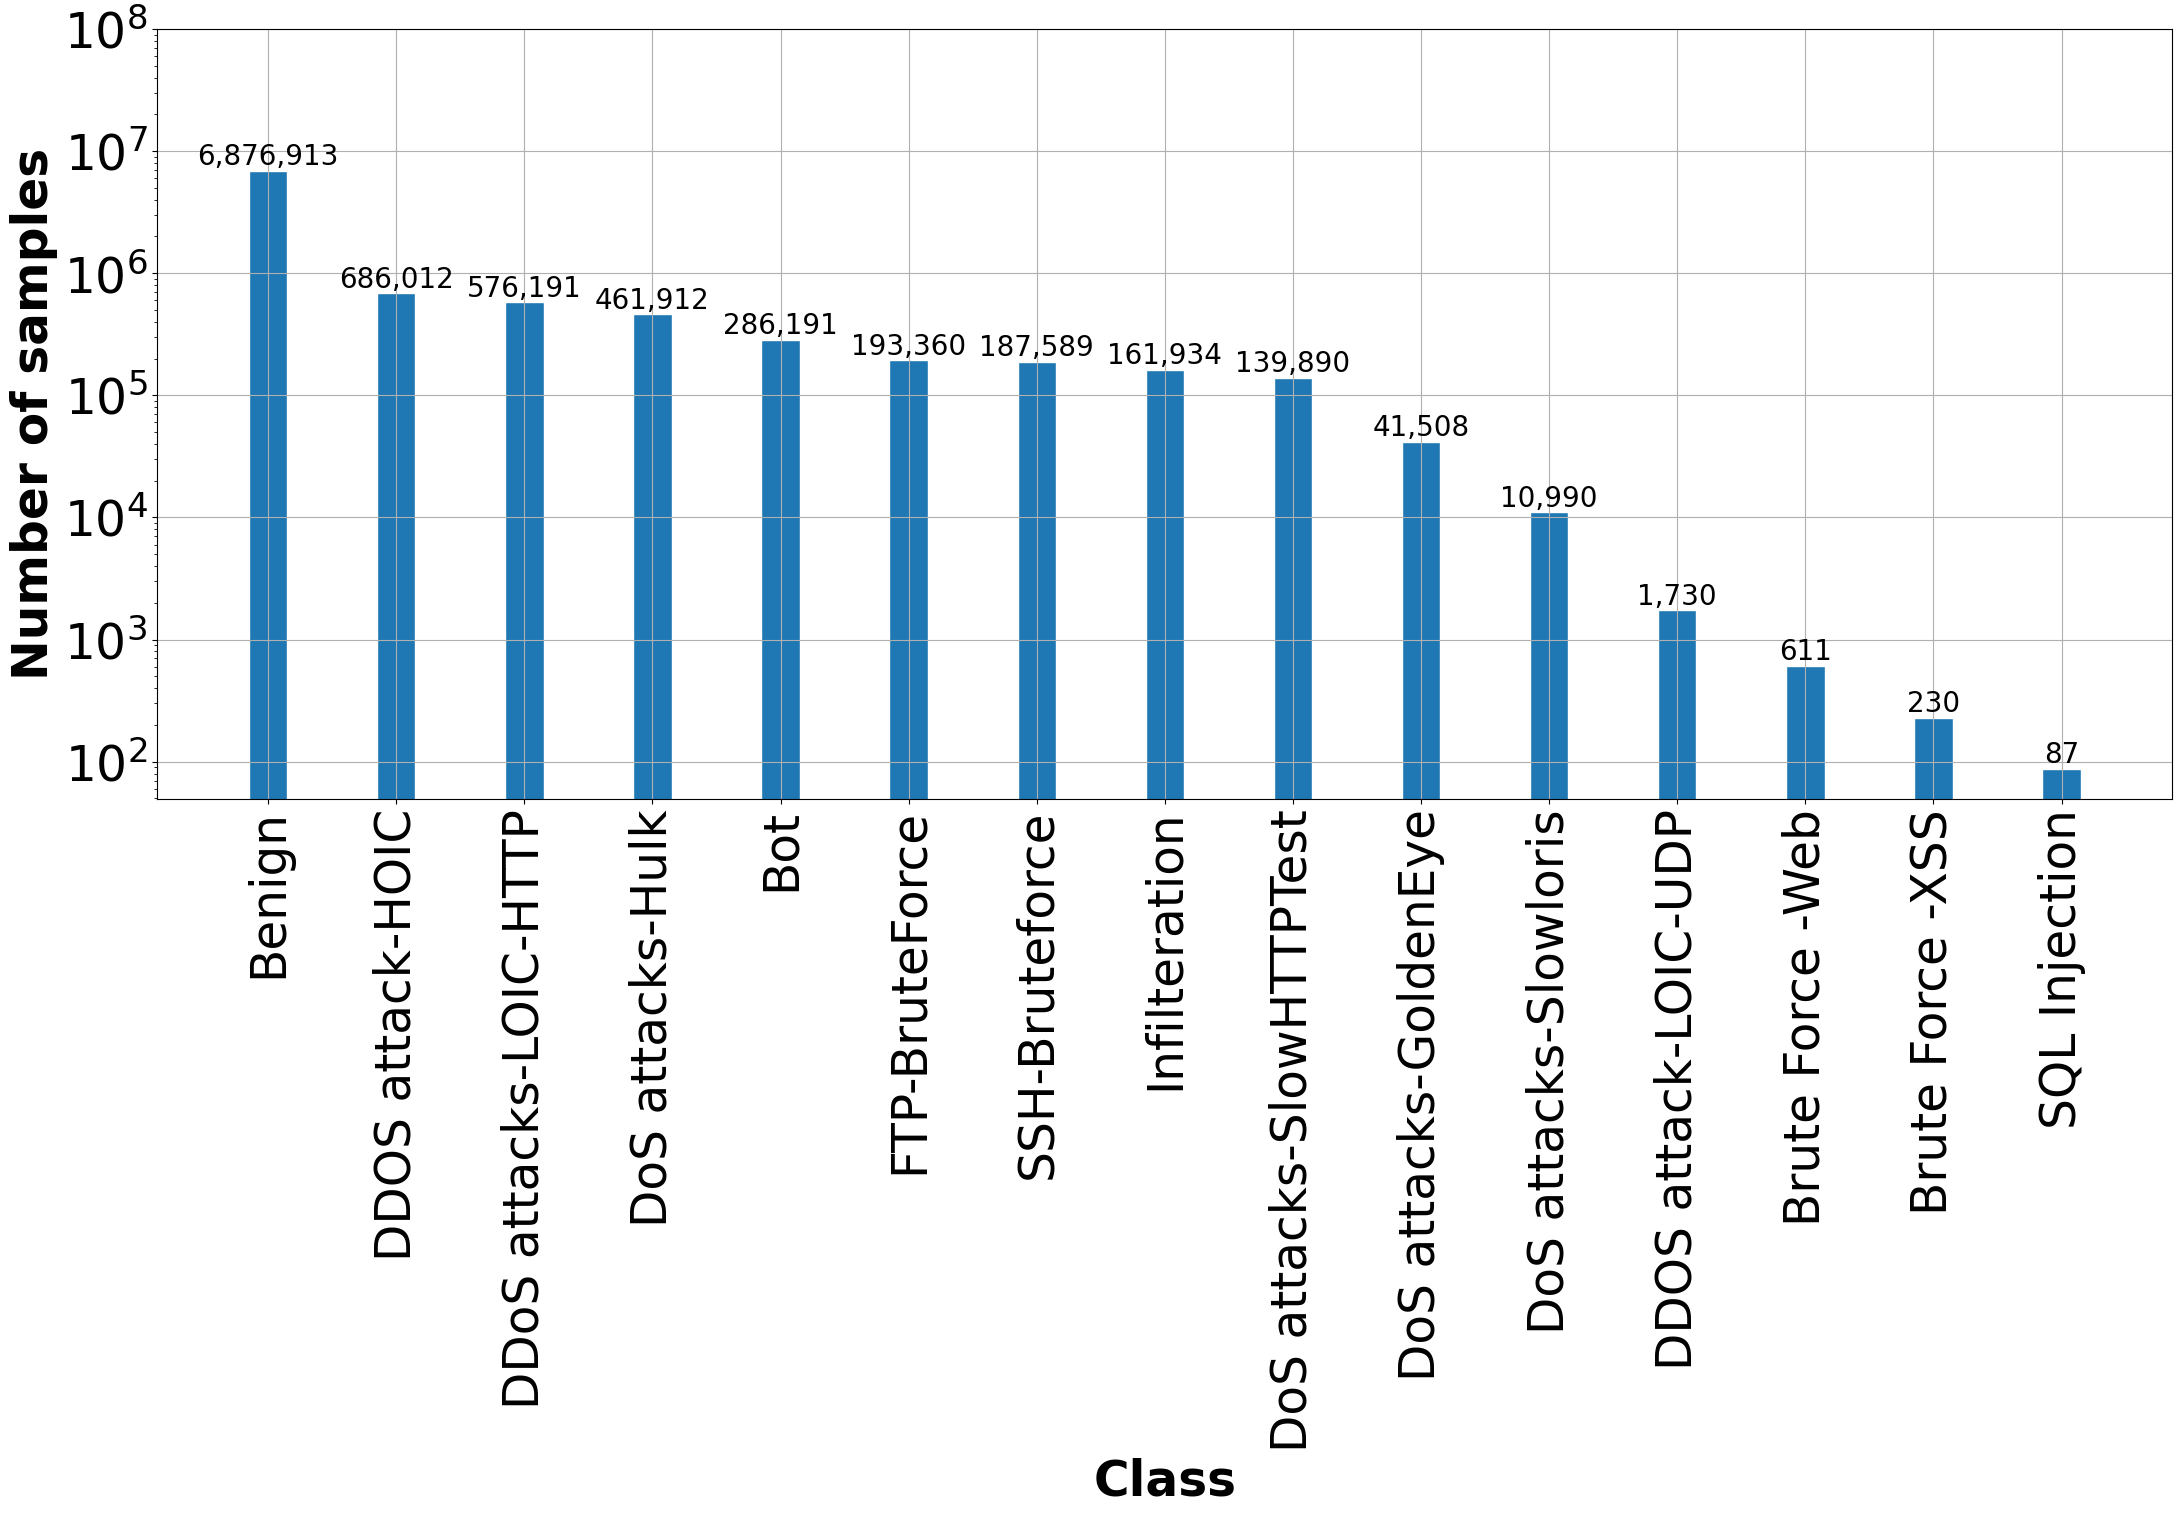

In [ ]:
# set width of bars
barWidth = 0.30

# set heights of bars
bars1 = list(merged_df['total_count'])

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# Make the plot
#fig = plt.figure(figsize = (20, 5))
fig, ax = plt.subplots(figsize = (26, 10))
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white', log=True)
plt.rcParams.update({'font.size': 20})
autolabel(rects1)
plt.rcParams.update({'font.size': 35})


# Add xticks on the middle of the group bars
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Number of samples', fontweight='bold')
plt.xticks([r  for r in range(len(bars1))], list(merged_df['Label']))
plt.xticks(rotation=90)
plt.ylim((0, 10**8))
plt.grid()
# Create legend & Show graphic
plt.savefig('dataset_dist.pdf', bbox_inches="tight")
plt.savefig('dataset_dist.png', bbox_inches="tight")

plt.show()

In [ ]:
merged_df[[
    'Label',
    'total_count'
]]

,Label,count_df1,count_df2,total_count
0,Benign,5501091,1375822,6876913
1,Bot,229067,57124,286191
2,DDOS attack-HOIC,548207,137805,686012
3,DDoS attacks-LOIC-HTTP,461004,115187,576191
4,DoS attacks-Hulk,369964,91948,461912
5,DoS attacks-SlowHTTPTest,111735,28155,139890
6,FTP-BruteForce,154674,38686,193360
7,Infilteration,129723,32211,161934
8,SSH-Bruteforce,150123,37466,187589
9,DoS attacks-GoldenEye,33103,8405,41508


In [ ]:
explained_var = [0.16505728, 0.1325433,  0.08444081, 0.07450816, 0.06757306, 0.05377497,
 0.05111668, 0.0426197,  0.03931039, 0.0349954,  0.02949279, 0.02801139,
 0.02534582, 0.0167648, ]

explained_var_dict = {f"{k} {i}":np.round(v*100, 2) for i, k, v in zip(range(1, len(explained_var)+1), ['Component']*len(explained_var), explained_var)}




In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        desired_output = int(height)
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%.02f' % float(height),
                ha='center', va='bottom')

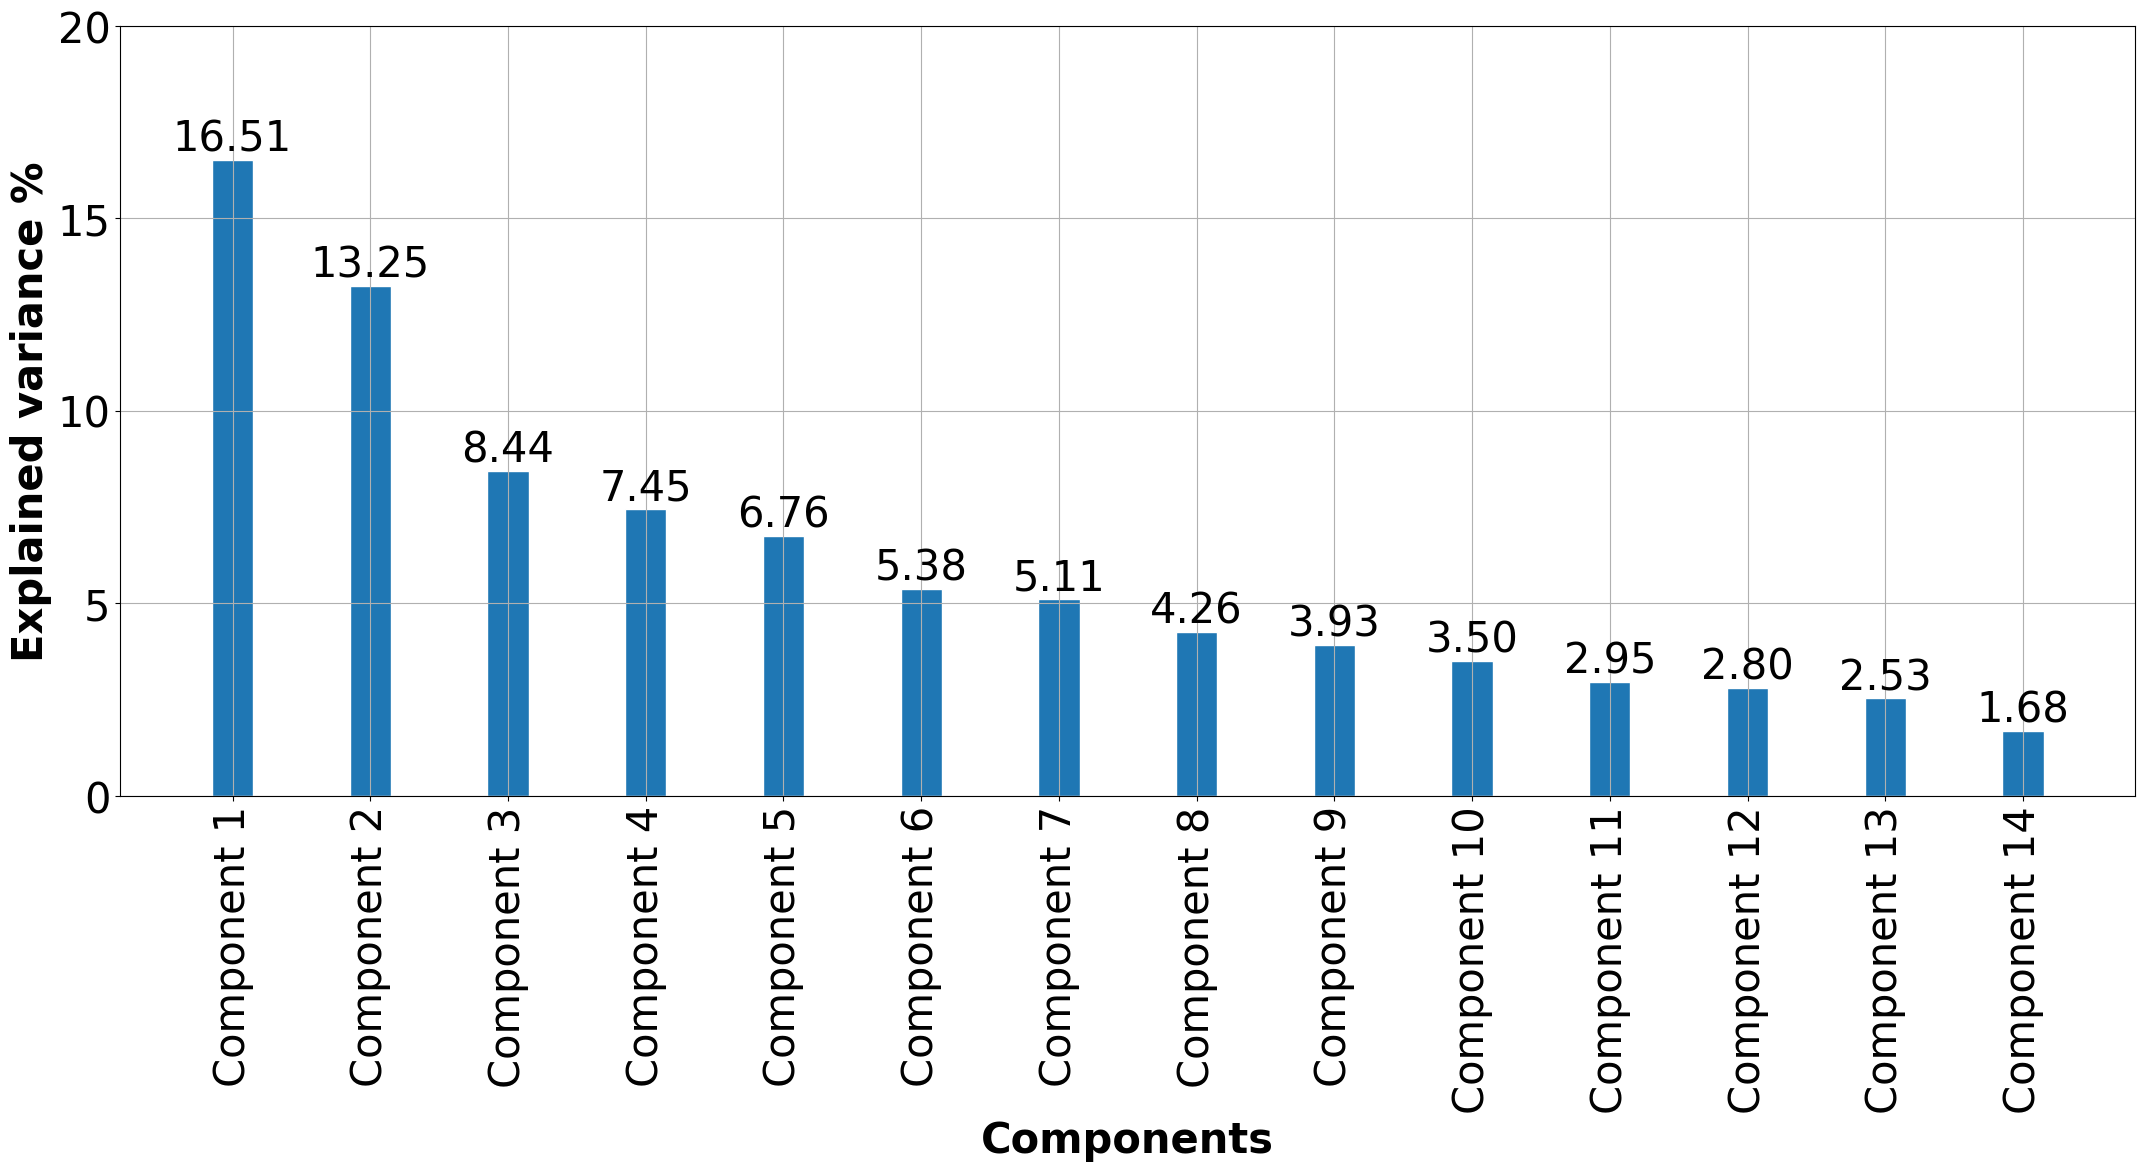

In [ ]:
# set width of bars
barWidth = 0.30

# set heights of bars
bars1 = list(explained_var_dict.values())

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# Make the plot
#fig = plt.figure(figsize = (20, 5))
fig, ax = plt.subplots(figsize = (26, 10))
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.rcParams.update({'font.size': 30})
autolabel(rects1)
plt.rcParams.update({'font.size': 35})


# Add xticks on the middle of the group bars
plt.xlabel('Components', fontweight='bold')
plt.ylabel('Explained variance %', fontweight='bold')
plt.xticks([r  for r in range(len(bars1))], list(explained_var_dict.keys()))
plt.xticks(rotation=90)
plt.ylim((0, 20))
plt.grid()
# Create legend & Show graphic
plt.savefig('pca_explained_var.pdf', bbox_inches="tight")
plt.savefig('pca_explained_var.png', bbox_inches="tight")

plt.show()

In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        desired_output = int(height)
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                "{:,}".format(int(height)),
                ha='center', va='bottom')

In [ ]:
training_time = {
    "Decision tree":414.74,
    "Random forest": 554.05,
    "Logistic regression":800.82
}

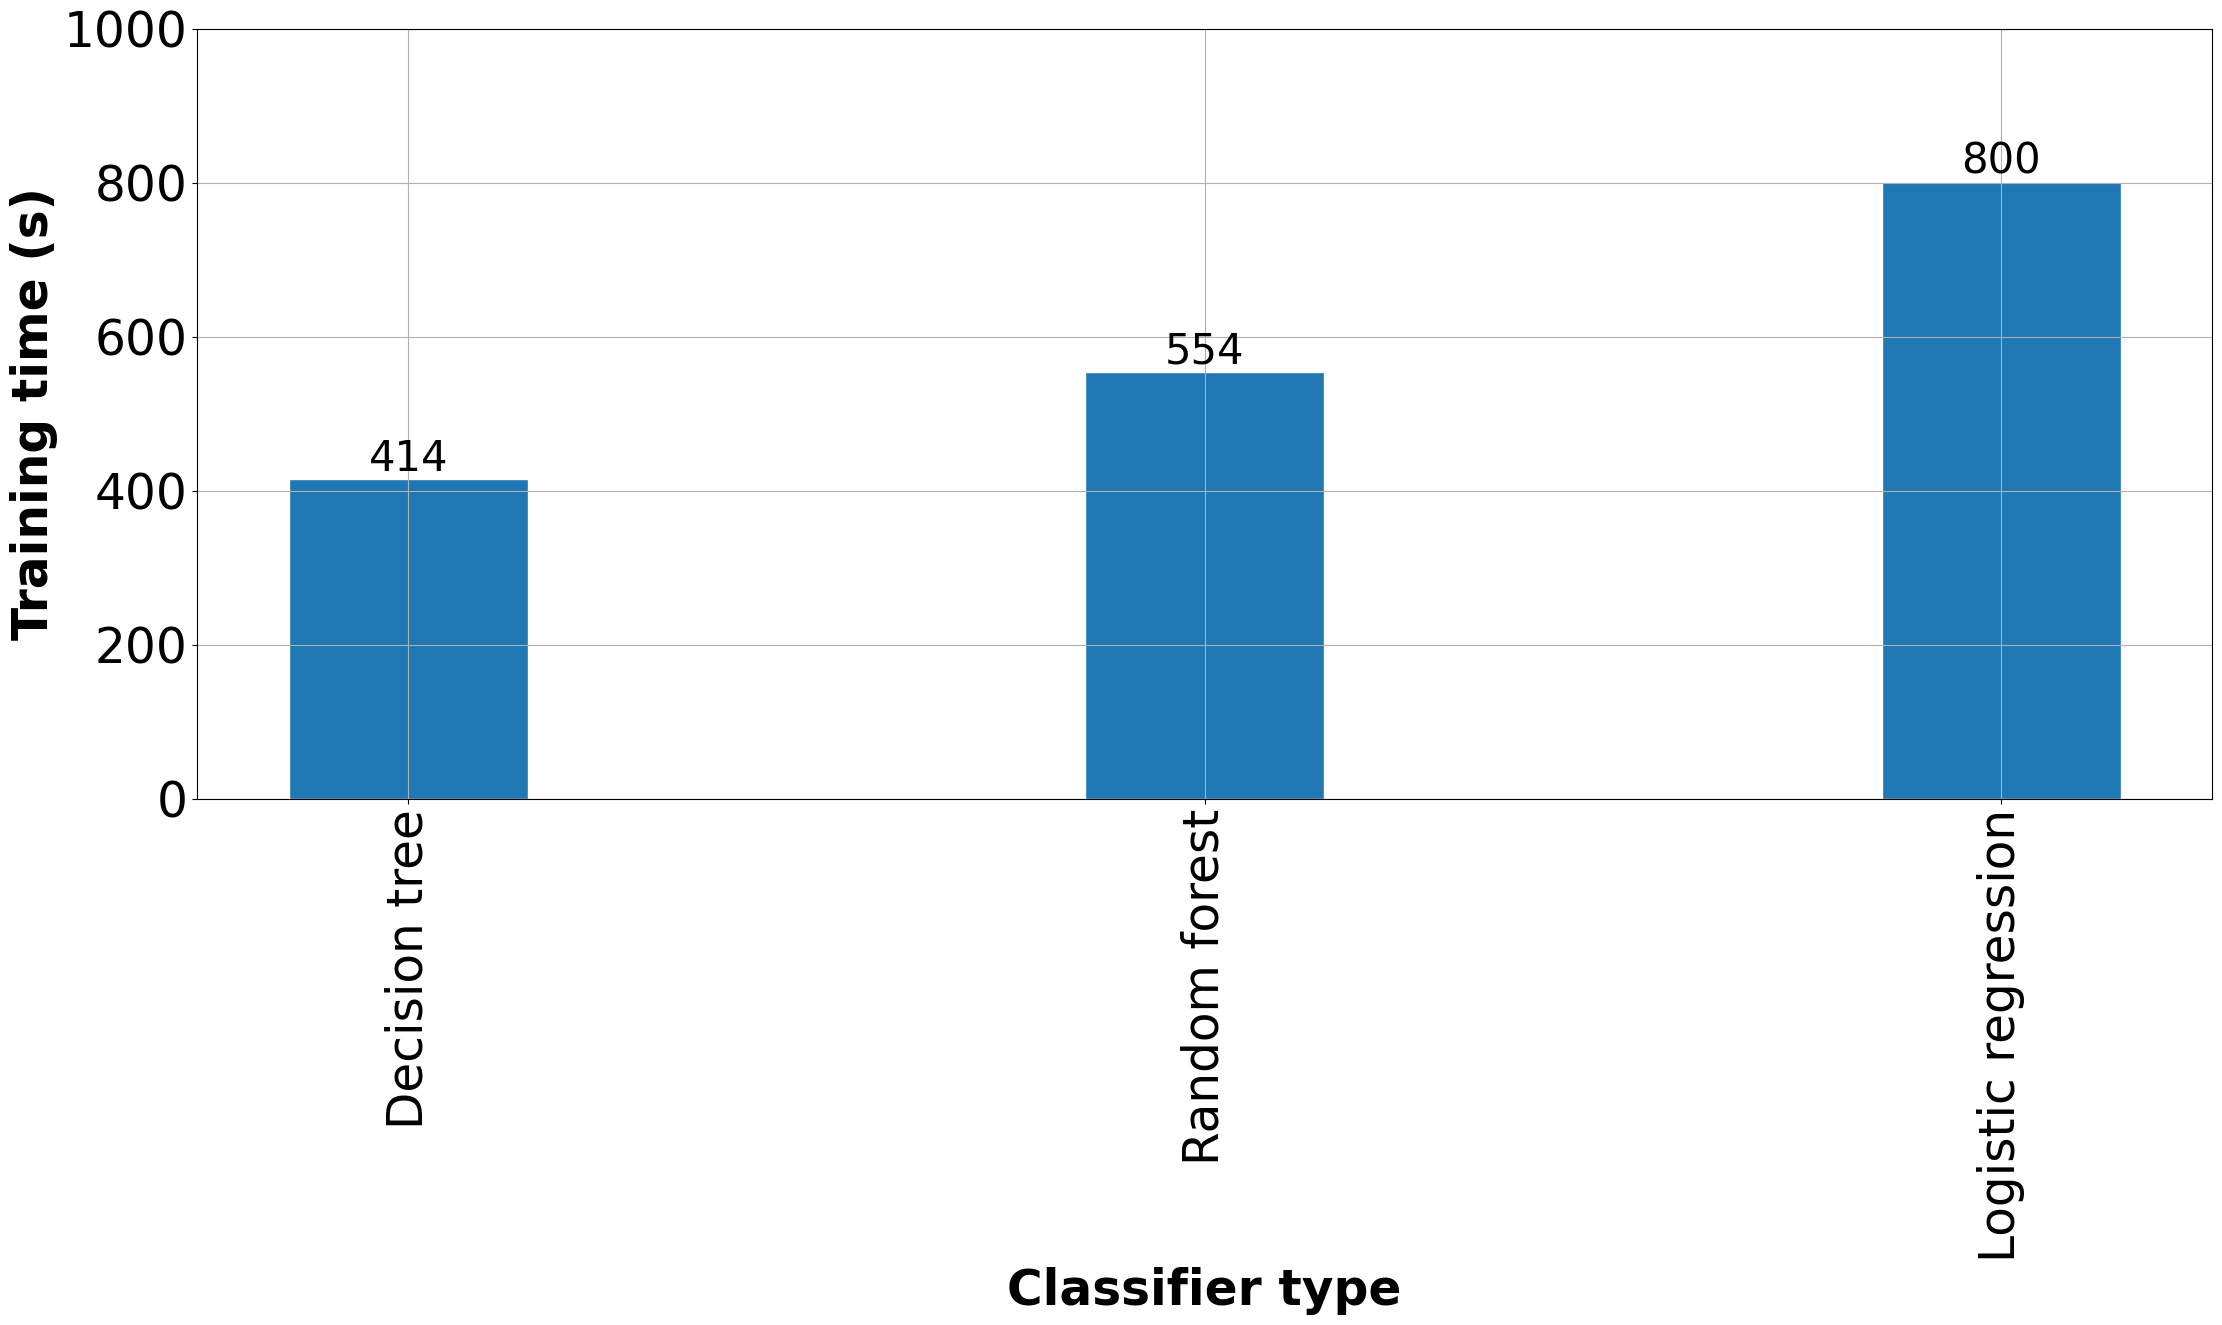

In [ ]:
# set width of bars
barWidth = 0.30

# set heights of bars
bars1 = list(training_time.values())

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# Make the plot
#fig = plt.figure(figsize = (20, 5))
fig, ax = plt.subplots(figsize = (26, 10))
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.rcParams.update({'font.size': 30})
autolabel(rects1)
plt.rcParams.update({'font.size': 35})


# Add xticks on the middle of the group bars
plt.xlabel('Classifier type', fontweight='bold')
plt.ylabel('Training time (s)', fontweight='bold')
plt.xticks([r  for r in range(len(bars1))], list(training_time.keys()))
plt.xticks(rotation=90)
plt.ylim((0, 1000))
plt.grid()
# Create legend & Show graphic
plt.savefig('training_time.pdf', bbox_inches="tight")
plt.savefig('training_time.png', bbox_inches="tight")

plt.show()

In [ ]:
import math

In [ ]:
throughput_time = {
    "Decision tree":math.ceil(1/(0.00025*10e-3)),
    "Random forest": math.ceil(1/(0.00012*10e-3)),
    "Logistic regression": math.ceil(1/(0.0003*10e-3))
}

In [ ]:
throughput_time

{'Decision tree': 400000,
 'Random forest': 833334,
 'Logistic regression': 333334}

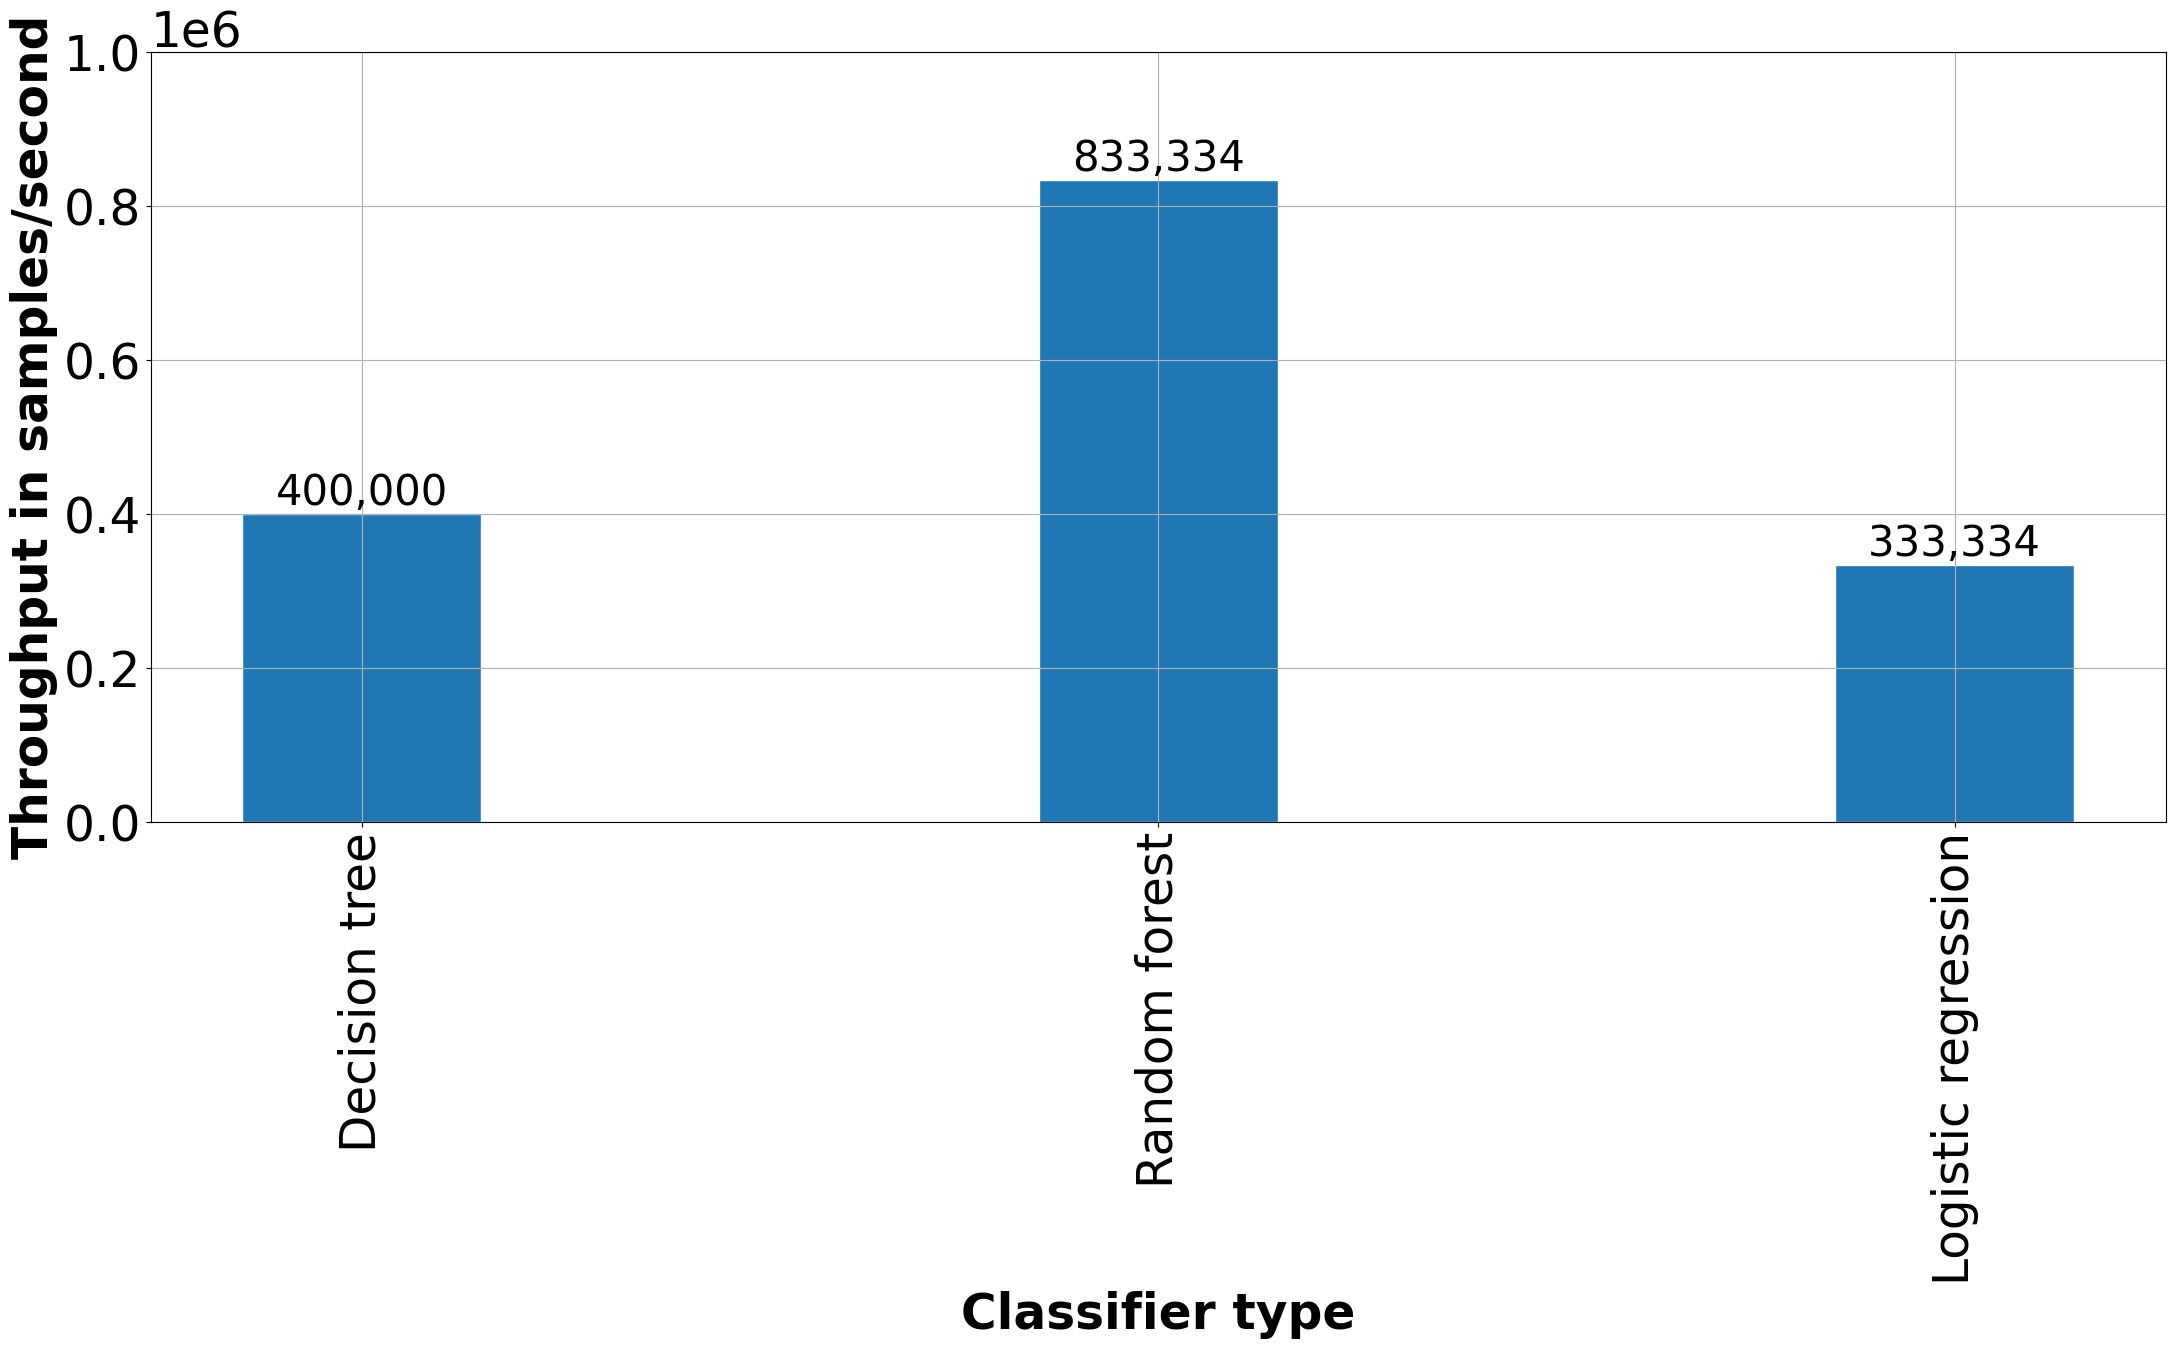

In [ ]:
# set width of bars
barWidth = 0.30

# set heights of bars
bars1 = list(throughput_time.values())

# Set position of bar on X axis
r1 = np.arange(len(bars1))
# Make the plot
#fig = plt.figure(figsize = (20, 5))
fig, ax = plt.subplots(figsize = (26, 10))
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white')#, log=True)
plt.rcParams.update({'font.size': 30})
autolabel(rects1)
plt.rcParams.update({'font.size': 35})


# Add xticks on the middle of the group bars
plt.xlabel('Classifier type', fontweight='bold')
plt.ylabel('Throughput in samples/second', fontweight='bold')
plt.xticks([r  for r in range(len(bars1))], list(throughput_time.keys()))
plt.xticks(rotation=90)
plt.ylim((0, 10**6))
plt.grid()
# Create legend & Show graphic
plt.savefig('throughput_time_exp2.pdf', bbox_inches="tight")
plt.savefig('throughput_time_exp2.png', bbox_inches="tight")

plt.show()

In [ ]:
text = """

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.9420
F1 Score  = 0.9288
Precision = 0.9256
Recall    = 0.9420

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9796
Recall    = 0.8469
F1 Score  = 0.9084

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9997
Recall    = 0.9993
F1 Score  = 0.9995

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9998
F1 Score  = 0.9985

Metrics for class 4.0 Bot:
Precision = 0.9832
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9969
Recall    = 0.9926
F1 Score  = 0.9948

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9995
Recall    = 0.9988
F1 Score  = 0.9991

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9916
Recall    = 0.9953
F1 Score  = 0.9935

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9965
Recall    = 1.0000
F1 Score  = 0.9982

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9988
Recall    = 1.0000
F1 Score  = 0.9994

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 0.9999
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

df_result = pd.DataFrame([])

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Decision tree", "Decision tree"],
           "Sample": ["Train", "Train"],
           "Class": ["Benign", 'Attack']
}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)

   Precision    Recall  F1 Score          Model Sample   Class
0   0.979600  0.846900  0.908400  Decision tree  Train  Benign
1   0.996171  0.998964  0.997557  Decision tree  Train  Attack


In [ ]:
df_results_classes = pd.DataFrame([])

In [ ]:
data = []
model_name = "Decision tree"  # Placeholder for model name
sample_type = "Train"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
5,Decision tree,Train,FTP-BruteForce,0.9969,0.9926,0.9948
6,Decision tree,Train,SSH-Bruteforce,0.9995,0.9988,0.9991
7,Decision tree,Train,Infilteration,0.9832,1.0000,0.9915
8,Decision tree,Train,DoS attacks-SlowHTTPTest,0.9916,0.9953,0.9935
9,Decision tree,Train,DoS attacks-GoldenEye,0.9965,1.0000,0.9982


In [ ]:
text = """

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.9422
F1 Score  = 0.9291
Precision = 0.9259
Recall    = 0.9422

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9794
Recall    = 0.8476
F1 Score  = 0.9088

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9997
Recall    = 0.9992
F1 Score  = 0.9995

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9998
F1 Score  = 0.9985

Metrics for class 4.0 Bot:
Precision = 0.9833
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9969
Recall    = 0.9926
F1 Score  = 0.9948

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9995
Recall    = 0.9988
F1 Score  = 0.9991

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9917
Recall    = 0.9952
F1 Score  = 0.9935

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9965
Recall    = 1.0000
F1 Score  = 0.9982

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9989
Recall    = 1.0000
F1 Score  = 0.9994

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 0.9999
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
# Store in dictionary
# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Decision tree", "Decision tree"],
           "Sample": ["Test", "Test"],
           "Class": ["Benign", 'Attack']

}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)

   Precision    Recall  F1 Score          Model Sample   Class
0   0.979600  0.846900  0.908400  Decision tree  Train  Benign
1   0.996171  0.998964  0.997557  Decision tree  Train  Attack
0   0.979400  0.847600  0.908800  Decision tree   Test  Benign
1   0.996193  0.998950  0.997557  Decision tree   Test  Attack


In [ ]:
data = []
model_name = "Decision tree"  # Placeholder for model name
sample_type = "Test"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
5,Decision tree,Train,FTP-BruteForce,0.9969,0.9926,0.9948
6,Decision tree,Train,SSH-Bruteforce,0.9995,0.9988,0.9991
7,Decision tree,Train,Infilteration,0.9832,1.0000,0.9915
8,Decision tree,Train,DoS attacks-SlowHTTPTest,0.9916,0.9953,0.9935
9,Decision tree,Train,DoS attacks-GoldenEye,0.9965,1.0000,0.9982


In [ ]:
text = """

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.9235
F1 Score  = 0.9013
Precision = 0.8980
Recall    = 0.9235

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9900
Recall    = 0.7944
F1 Score  = 0.8815

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9960
Recall    = 1.0000
F1 Score  = 0.9980

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9987
F1 Score  = 0.9980

Metrics for class 4.0 Bot:
Precision = 0.9843
Recall    = 1.0000
F1 Score  = 0.9921

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9995
Recall    = 0.9832
F1 Score  = 0.9913

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9853
Recall    = 1.0000
F1 Score  = 0.9926

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9854
Recall    = 1.0000
F1 Score  = 0.9927

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9957
Recall    = 1.0000
F1 Score  = 0.9978

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9988
Recall    = 1.0000
F1 Score  = 0.9994

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 0.9998
Recall    = 1.0000
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Random forest", "Random forest"],
            "Sample": ["Train", "Train"],
           "Class": ["Benign", 'Attack']

}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)

   Precision    Recall  F1 Score          Model Sample   Class
0   0.979600  0.846900  0.908400  Decision tree  Train  Benign
1   0.996171  0.998964  0.997557  Decision tree  Train  Attack
0   0.979400  0.847600  0.908800  Decision tree   Test  Benign
1   0.996193  0.998950  0.997557  Decision tree   Test  Attack
0   0.990000  0.794400  0.881500  Random forest  Train  Benign
1   0.994650  0.998707  0.996664  Random forest  Train  Attack


In [ ]:
data = []
model_name = "Random forest"  # Placeholder for model name
sample_type = "Train"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
5,Decision tree,Train,FTP-BruteForce,0.9969,0.9926,0.9948
6,Decision tree,Train,SSH-Bruteforce,0.9995,0.9988,0.9991
7,Decision tree,Train,Infilteration,0.9832,1.0000,0.9915
8,Decision tree,Train,DoS attacks-SlowHTTPTest,0.9916,0.9953,0.9935
9,Decision tree,Train,DoS attacks-GoldenEye,0.9965,1.0000,0.9982


In [ ]:
text = """

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.9239
F1 Score  = 0.9018
Precision = 0.8985
Recall    = 0.9239

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.9896
Recall    = 0.7954
F1 Score  = 0.8819

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9961
Recall    = 1.0000
F1 Score  = 0.9981

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9987
F1 Score  = 0.9979

Metrics for class 4.0 Bot:
Precision = 0.9844
Recall    = 1.0000
F1 Score  = 0.9921

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9995
Recall    = 0.9832
F1 Score  = 0.9913

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9853
Recall    = 1.0000
F1 Score  = 0.9926

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 1.0000
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9856
Recall    = 1.0000
F1 Score  = 0.9927

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9957
Recall    = 1.0000
F1 Score  = 0.9978

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9989
Recall    = 1.0000
F1 Score  = 0.9994

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 0.9998
Recall    = 1.0000
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Random forest", "Random forest"],
           "Sample": ["Test", "Test"],
           "Class": ["Benign", 'Attack']

}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)


   Precision    Recall  F1 Score          Model Sample   Class
0   0.979600  0.846900  0.908400  Decision tree  Train  Benign
1   0.996171  0.998964  0.997557  Decision tree  Train  Attack
0   0.979400  0.847600  0.908800  Decision tree   Test  Benign
1   0.996193  0.998950  0.997557  Decision tree   Test  Attack
0   0.990000  0.794400  0.881500  Random forest  Train  Benign
1   0.994650  0.998707  0.996664  Random forest  Train  Attack
0   0.989600  0.795400  0.881900  Random forest   Test  Benign
1   0.994686  0.998707  0.996664  Random forest   Test  Attack


In [ ]:
data = []
model_name = "Random forest"  # Placeholder for model name
sample_type = "Test"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
5,Decision tree,Train,FTP-BruteForce,0.9969,0.9926,0.9948
6,Decision tree,Train,SSH-Bruteforce,0.9995,0.9988,0.9991
7,Decision tree,Train,Infilteration,0.9832,1.0000,0.9915
8,Decision tree,Train,DoS attacks-SlowHTTPTest,0.9916,0.9953,0.9935
9,Decision tree,Train,DoS attacks-GoldenEye,0.9965,1.0000,0.9982


In [ ]:
text = """

Training Data Classification Report:

Overall Metrics:
Accuracy  = 0.7924
F1 Score  = 0.7260
Precision = 0.7079
Recall    = 0.7924

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.8765
Recall    = 0.3853
F1 Score  = 0.5353

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 0.9281
Recall    = 0.9906
F1 Score  = 0.9584

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9692
Recall    = 0.9965
F1 Score  = 0.9826

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9972
F1 Score  = 0.9972

Metrics for class 4.0 Bot:
Precision = 0.9702
Recall    = 0.9999
F1 Score  = 0.9849

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9975
Recall    = 0.9829
F1 Score  = 0.9901

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9805
Recall    = 1.0000
F1 Score  = 0.9902

Metrics for class 7.0 Infilteration:
Precision = 0.9832
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9854
Recall    = 1.0000
F1 Score  = 0.9927

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9957
Recall    = 1.0000
F1 Score  = 0.9978

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9991
Recall    = 0.9996
F1 Score  = 0.9993

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Logistic regression", "Logistic regression"],
           "Sample": ["Train", "Train"],
           "Class": ["Benign", 'Attack']

}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)

   Precision    Recall  F1 Score                Model Sample   Class
0   0.979600  0.846900  0.908400        Decision tree  Train  Benign
1   0.996171  0.998964  0.997557        Decision tree  Train  Attack
0   0.979400  0.847600  0.908800        Decision tree   Test  Benign
1   0.996193  0.998950  0.997557        Decision tree   Test  Attack
0   0.990000  0.794400  0.881500        Random forest  Train  Benign
1   0.994650  0.998707  0.996664        Random forest  Train  Attack
0   0.989600  0.795400  0.881900        Random forest   Test  Benign
1   0.994686  0.998707  0.996664        Random forest   Test  Attack
0   0.876500  0.385300  0.535300  Logistic regression  Train  Benign
1   0.986143  0.997607  0.991757  Logistic regression  Train  Attack


In [ ]:
data = []
model_name = "Logistic regression"  # Placeholder for model name
sample_type = "Train"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
...,...,...,...,...,...,...
10,Logistic regression,Train,DoS attacks-Slowloris,0.9991,0.9996,0.9993
11,Logistic regression,Train,DDOS attack-LOIC-UDP,1.0000,0.9999,0.9999
12,Logistic regression,Train,Brute Force -Web,0.9999,1.0000,1.0000
13,Logistic regression,Train,Brute Force -XSS,1.0000,1.0000,1.0000


In [ ]:
text = """

Test Data Classification Report:

Overall Metrics:
Accuracy  = 0.7927
F1 Score  = 0.7264
Precision = 0.7079
Recall    = 0.7927

Per-Class Metrics:

Metrics for class 0.0 Benign:
Precision = 0.8764
Recall    = 0.3856
F1 Score  = 0.5356

Metrics for class 1.0 DDOS attack-HOIC:
Precision = 0.9280
Recall    = 0.9907
F1 Score  = 0.9583

Metrics for class 2.0 DDoS attacks-LOIC-HTTP:
Precision = 0.9692
Recall    = 0.9965
F1 Score  = 0.9827

Metrics for class 3.0 DoS attacks-Hulk:
Precision = 0.9972
Recall    = 0.9972
F1 Score  = 0.9972

Metrics for class 4.0 Bot:
Precision = 0.9703
Recall    = 0.9999
F1 Score  = 0.9849

Metrics for class 5.0 FTP-BruteForce:
Precision = 0.9975
Recall    = 0.9829
F1 Score  = 0.9901

Metrics for class 6.0 SSH-Bruteforce:
Precision = 0.9805
Recall    = 1.0000
F1 Score  = 0.9902

Metrics for class 7.0 Infilteration:
Precision = 0.9833
Recall    = 0.9999
F1 Score  = 0.9915

Metrics for class 8.0 DoS attacks-SlowHTTPTest:
Precision = 0.9856
Recall    = 1.0000
F1 Score  = 0.9927

Metrics for class 9.0 DoS attacks-GoldenEye:
Precision = 0.9957
Recall    = 1.0000
F1 Score  = 0.9978

Metrics for class 10.0 DoS attacks-Slowloris:
Precision = 0.9991
Recall    = 0.9996
F1 Score  = 0.9994

Metrics for class 11.0 DDOS attack-LOIC-UDP:
Precision = 1.0000
Recall    = 0.9999
F1 Score  = 0.9999

Metrics for class 12.0 Brute Force -Web:
Precision = 0.9999
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 13.0 Brute Force -XSS:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000

Metrics for class 14.0 SQL Injection:
Precision = 1.0000
Recall    = 1.0000
F1 Score  = 1.0000


"""

# Extract metrics for Benign
benign_metrics = re.search(r"Metrics for class 0\.0 Benign:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
benign_precision = float(benign_metrics.group(1))
benign_recall = float(benign_metrics.group(2))
benign_f1 = float(benign_metrics.group(3))

# Extract all other class metrics
other_classes = re.findall(r"Metrics for class \d+\.\d+ [^\n]+:\nPrecision = ([\d.]+)\nRecall    = ([\d.]+)\nF1 Score  = ([\d.]+)", text)
other_precisions = [float(m[0]) for m in other_classes[1:]]  # Skip class 0.0
other_recalls = [float(m[1]) for m in other_classes[1:]]
other_f1s = [float(m[2]) for m in other_classes[1:]]

# Compute averages
avg_precision = sum(other_precisions) / len(other_precisions)
avg_recall = sum(other_recalls) / len(other_recalls)
avg_f1 = sum(other_f1s) / len(other_f1s)

# Store in dictionary
result = {

           "Precision": [benign_precision, avg_precision],
           "Recall": [benign_recall, avg_recall],
           "F1 Score": [benign_f1, avg_f1],
           "Model": ["Logistic regression", "Logistic regression"],
           "Sample": ["Test", "Test"],
           "Class": ["Benign", 'Attack']

}

df_temp = pd.DataFrame(result)

df_result = pd.concat([df_result, df_temp])

print(df_result)

   Precision    Recall  F1 Score                Model Sample   Class
0   0.979600  0.846900  0.908400        Decision tree  Train  Benign
1   0.996171  0.998964  0.997557        Decision tree  Train  Attack
0   0.979400  0.847600  0.908800        Decision tree   Test  Benign
1   0.996193  0.998950  0.997557        Decision tree   Test  Attack
0   0.990000  0.794400  0.881500        Random forest  Train  Benign
1   0.994650  0.998707  0.996664        Random forest  Train  Attack
0   0.989600  0.795400  0.881900        Random forest   Test  Benign
1   0.994686  0.998707  0.996664        Random forest   Test  Attack
0   0.876500  0.385300  0.535300  Logistic regression  Train  Benign
1   0.986143  0.997607  0.991757  Logistic regression  Train  Attack
0   0.876400  0.385600  0.535600  Logistic regression   Test  Benign
1   0.986164  0.997614  0.991764  Logistic regression   Test  Attack


In [ ]:
data = []
model_name = "Logistic regression"  # Placeholder for model name
sample_type = "Test"  # Inferred from "Training Data Classification Report"
current_class = None  # To keep track of the current class
precision, recall, f1_score = None, None, None  # Initialize metric variables

# Process each line of the text
lines = text.splitlines()
for line in lines:
    if line.startswith("Metrics for class"):
        # Extract class name
        parts = line.split(":")
        class_info = parts[0].replace("Metrics for class", "").strip()
        current_class = class_info.split(" ", 1)[1]  # Get the class description
    elif "Precision" in line or "Recall" in line or "F1 Score" in line:
        # Extract metric and value
        metric, value = line.split("=")
        metric, value = metric.strip(), float(value.strip())
        # Store values in the corresponding keys
        if metric == "Precision":
            precision = value
        elif metric == "Recall":
            recall = value
        elif metric == "F1 Score":
            f1_score = value
            # Add a row to the dataset after F1 Score since it's the last metric in the group
            if recall is None: continue
            data.append({
                "Model": model_name,
                "Sample": sample_type,
                "Class": current_class,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1_score
            })


# Convert parsed data into a DataFrame
data = pd.DataFrame(data)
df_results_classes = pd.concat([df_results_classes, data])
df_results_classes

,Model,Sample,Class,Precision,Recall,F1 Score
0,Decision tree,Train,Benign,0.9796,0.8469,0.9084
1,Decision tree,Train,DDOS attack-HOIC,1.0000,0.9999,0.9999
2,Decision tree,Train,DDoS attacks-LOIC-HTTP,0.9997,0.9993,0.9995
3,Decision tree,Train,DoS attacks-Hulk,0.9972,0.9998,0.9985
4,Decision tree,Train,Bot,0.9832,0.9999,0.9915
...,...,...,...,...,...,...
10,Logistic regression,Test,DoS attacks-Slowloris,0.9991,0.9996,0.9994
11,Logistic regression,Test,DDOS attack-LOIC-UDP,1.0000,0.9999,0.9999
12,Logistic regression,Test,Brute Force -Web,0.9999,1.0000,1.0000
13,Logistic regression,Test,Brute Force -XSS,1.0000,1.0000,1.0000


In [ ]:
df_results_classes.to_excel('results.xlsx')

In [ ]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '%.04f' % float(height),
                ha='center', va='bottom')

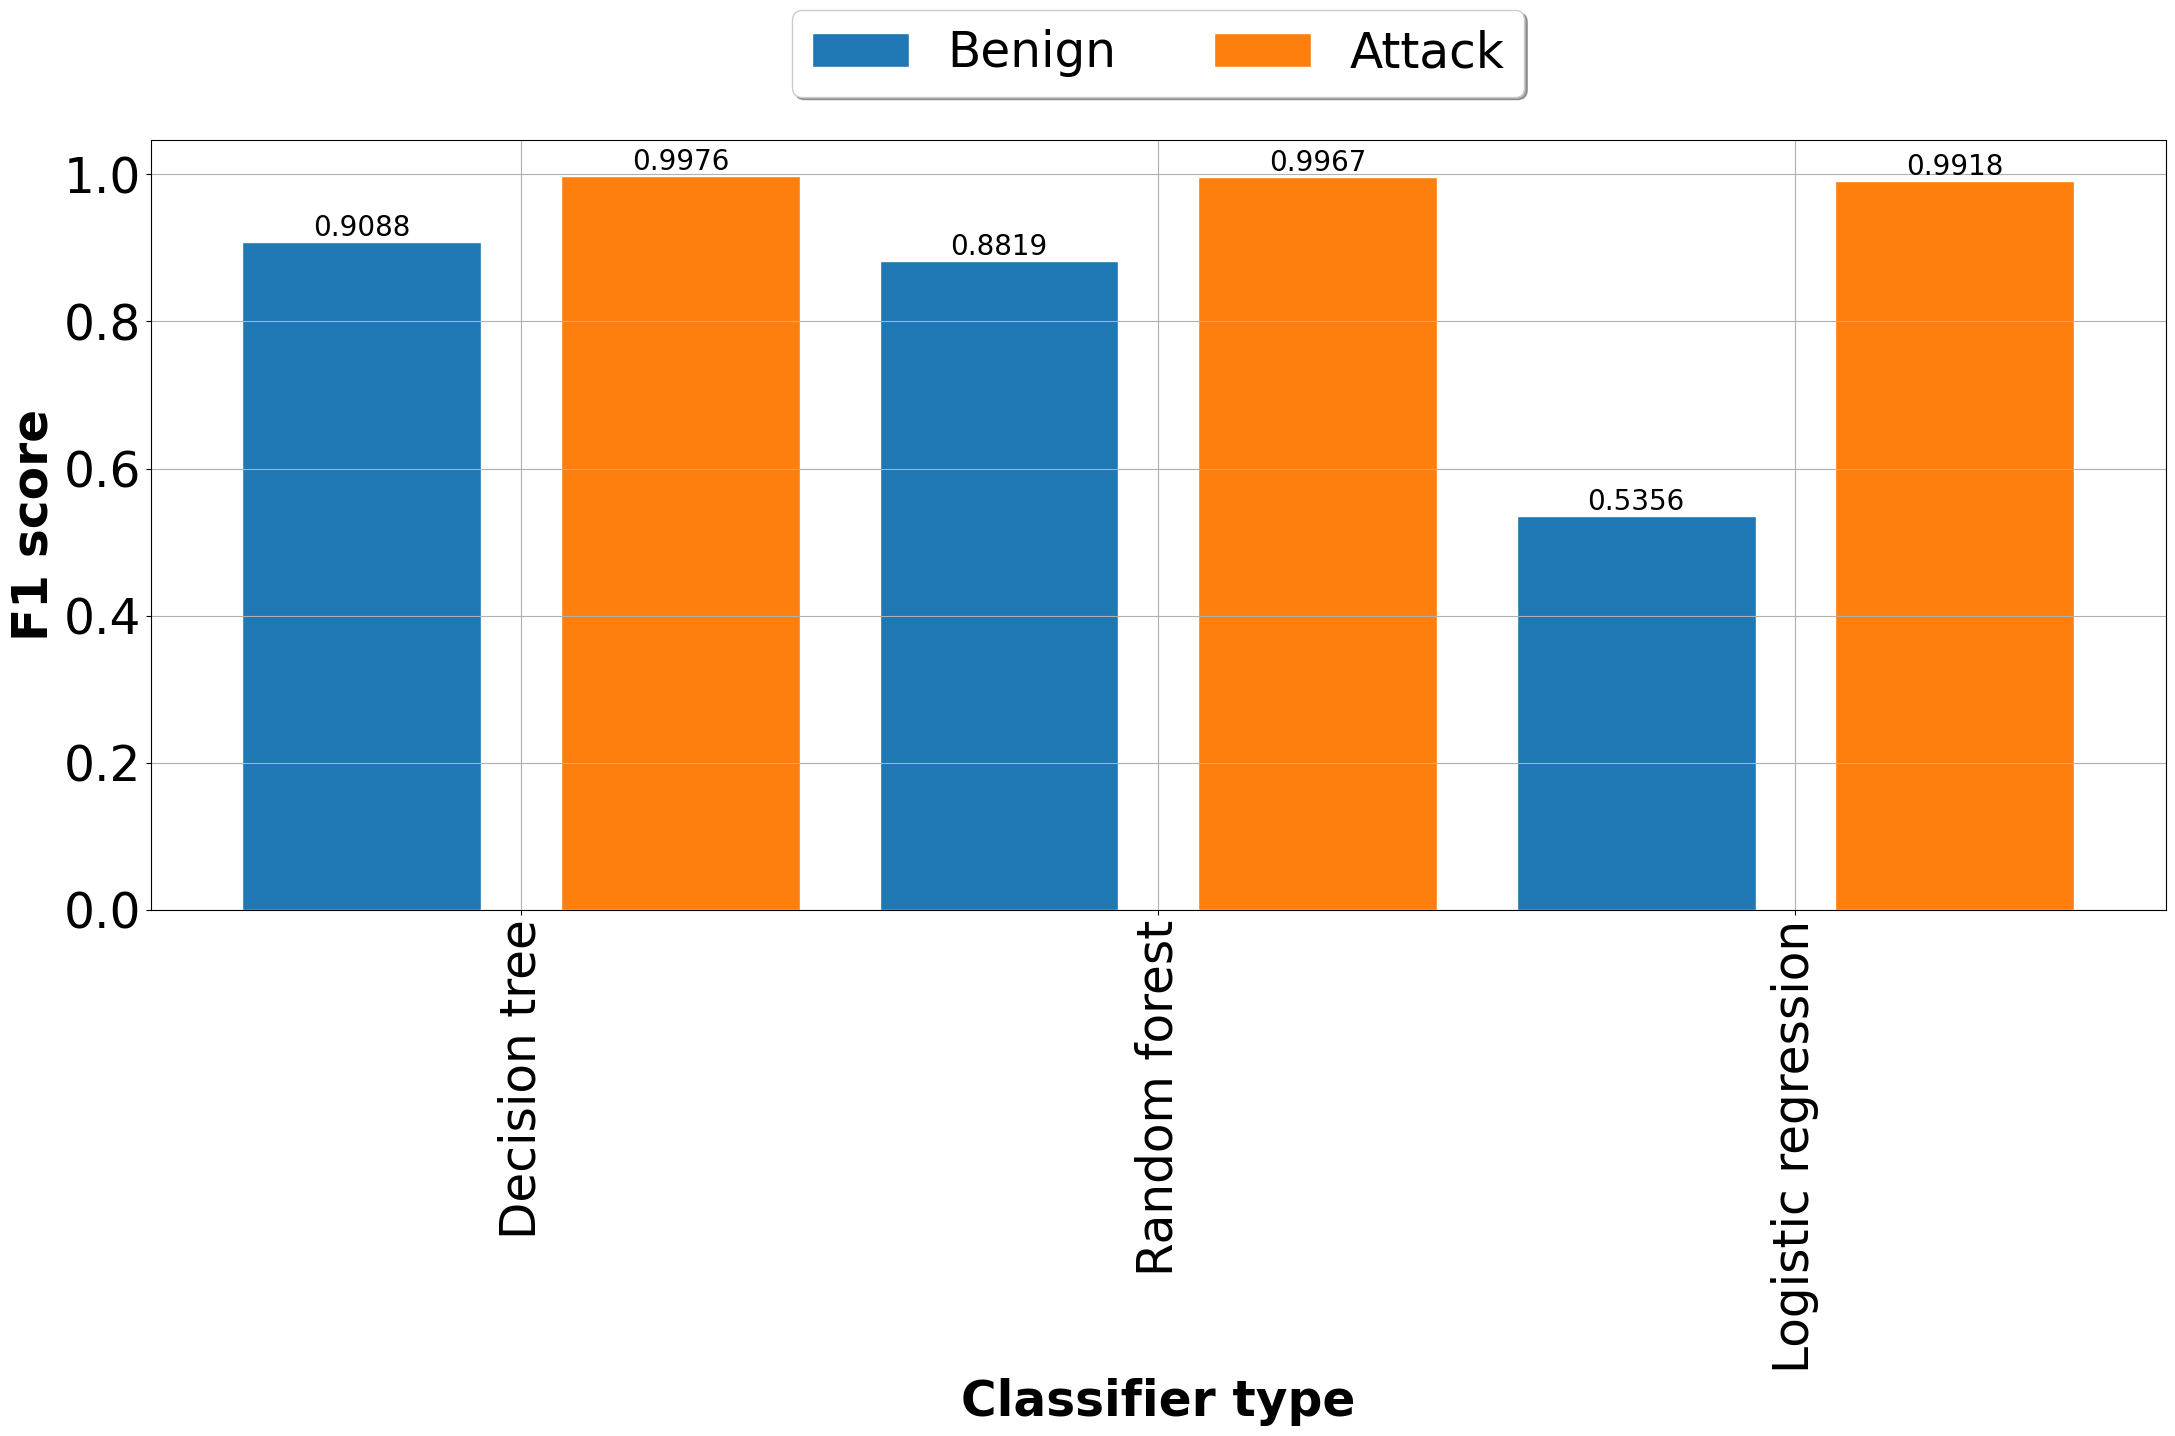

In [ ]:
# set width of bars
barWidth = 1.5

# set heights of bars
bars1 = list(df_result.loc[(df_result['Class'] == 'Benign') & (df_result['Sample'] == 'Test'), 'F1 Score'])
bars2 = list(df_result.loc[(df_result['Class'] == 'Attack') & (df_result['Sample'] == 'Test'), 'F1 Score'])

# Set position of bar on X axis
r1 = np.array([0, 4, 8])#np.arange(len(bars1))
r2 = [x + 2 for x in r1]
# Make the plot
#fig = plt.figure(figsize = (20, 5))
fig, ax = plt.subplots(figsize = (26, 10))
rects1 = plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Benign')#, log=True)
rects2 = plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Attack')#, log=True)

plt.rcParams.update({'font.size': 20})
autolabel(rects1)
autolabel(rects2)
plt.rcParams.update({'font.size': 35})


# Add xticks on the middle of the group bars
plt.xlabel('Classifier type', fontweight='bold')
plt.ylabel('F1 score', fontweight='bold')
plt.xticks([r + 2/2 for r in range(0,10,4)], list(df_result['Model'].unique()))
plt.xticks(rotation=90)
plt.grid()
# Create legend & Show graphic
#plt.legend(prop={'size': 35}, loc = "upper right")
# Shrink current axis's height by 10% on the bottom
# Shrink current axis by 20%
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)

plt.savefig('f1score_exp2.pdf', bbox_inches="tight")
plt.savefig('f1score_exp2.png', bbox_inches="tight")
plt.show()


In [ ]:
df_result

,Precision,Recall,F1 Score,Model,Sample,Class
0,0.979600,0.846900,0.908400,Decision tree,Train,Benign
1,0.996171,0.998964,0.997557,Decision tree,Train,Attack
0,0.979400,0.847600,0.908800,Decision tree,Test,Benign
1,0.996193,0.998950,0.997557,Decision tree,Test,Attack
0,0.990000,0.794400,0.881500,Random forest,Train,Benign
1,0.994650,0.998707,0.996664,Random forest,Train,Attack
0,0.989600,0.795400,0.881900,Random forest,Test,Benign
1,0.994686,0.998707,0.996664,Random forest,Test,Attack
0,0.876500,0.385300,0.535300,Logistic regression,Train,Benign
1,0.986143,0.997607,0.991757,Logistic regression,Train,Attack
